# Iris Scatterplot
### A simple example of using a bl.ock as the basis for a D3 visualization in Jupyter

Using this [bl.ocks example](http://bl.ocks.org/mbostock/3887118) as a template, we will construct a scatterplot of the canonical Iris dataset.

#### Notebook Config

In [1]:
from IPython.core.display import display, HTML
from string import Template
import json, random
import networkx as nx
import numpy as np

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [194]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

In [3]:
HTML('<script src="lib/d3/d3.min.js"></script>')

In [4]:
def replace_nodes(G0, Ns, N0):
    G0.add_node(N0, X="X")

    head = Ns[0]
    tail = Ns[-1]
    
    p = G0.predecessors(Ns[0])
    if len(p) == 1:
        p = p[0]
        G0.add_edge(p, N0)
        
    n = G0.successors(Ns[-1])
    if len(n) == 1:
        n = n[0]
        G0.add_edge(N0, n)
    
    G0.remove_nodes_from(Ns)

def reduce_graph(G0):
    G1 = G0.copy()
    G2 = G0.copy()
    nodes_to_remove = []
    for n in G1.nodes():
        if len(G1.successors(n)) > 1 or len(G1.predecessors(n)) > 1:
            if n[0] != "^" and n[-1] != "$":
                nodes_to_remove.append(n)
    G1.remove_nodes_from(nodes_to_remove)

    for ns in nx.weakly_connected_components(G1):
        ns = [n for n in ns if n[0] != "^" and n[-1] != "$"]
        if len(ns) == 0: continue
        contig = []
        n_sorted = nx.topological_sort(G1, ns)
        n_sorted = [n for n in n_sorted if n[0] != "^" and n[-1] != "$"]
        if len(n_sorted) <= 1: continue

        for kmer in n_sorted:
            assert len(G1.successors(kmer)) <= 1
            if len(contig) == 0:
                contig.append(kmer)
            else:
                contig.append(kmer[-1])
        replace_nodes(G2, n_sorted, "".join(contig))
        
    return G2

Generate the JSON for the force layout.

In [5]:
def get_group(w, w1):
    c = 0
    for c1, c2 in zip(w,w1):
        if c1 == c2:
            c += 1
            continue
        break
    return c

def set_g_json(seq, k, color, reduce_g = False):
    G=nx.DiGraph()
    #seq = "^"+seq+"$"
    for i in range(len(seq)-k+1):
        w1 = seq[i:i+k-1]
        w2 = seq[i+1:i+k]
        G.add_edge(w1, w2)
    if reduce_g == True:
        G = reduce_graph(G)
    def generateD3JSONForG(G, color):
        s = {"nodes":[], "links":[], "linksInteger":[]}
        name2Idx = {}
        c = 0
        for n in G.nodes():
            #print n
            g = len(G.neighbors(n))
            if "^" in n:
                s["nodes"].append({"name":n, "group":g, "fixed":True, "x":0,"y":150})
            elif "$" in n:
                s["nodes"].append({"name":n, "group":g, "fixed":True, "x":850,"y":150})
            else:
                s["nodes"].append({"name":n, "group":g})
            name2Idx[n] = c
            c += 1
        for e in G.edges():
            col = "rgb(0,0,255)"
            width = 1
            s["linksInteger"].append({"source":name2Idx[e[0]], "target":name2Idx[e[1]], "color":col, "width":width})
            s["links"].append({"source": e[0], "target": e[1], "type": color, "width":width})
#        return json.dumps(s)     
        return(s)
    n_json = generateD3JSONForG(G, color)
    return n_json


def buildDBG(seq, k, reduce_g = False):
    G=nx.DiGraph()
    #seq = "^"+seq+"$"
    for i in range(len(seq)-k+1):
        w1 = seq[i:i+k-1]
        w2 = seq[i+1:i+k]
        G.add_edge(w1, w2)
    if reduce_g == True:
        G = reduce_graph(G)
    return G
    #vis_cell.set_js_var("n_json", n_json)
   

In [6]:
dicSeqDummy1 = set_g_json("AATCGAGATAGA",5, "licensing", reduce_g=True)
dicSeqDummy2 = set_g_json("AATCGATATAGA",5, "suit", reduce_g=True)

#### CSS and JavaScript based on bl.ocks example

Note that in the below css_text, we have removed the 'body' style reference from the original bl.ocks text. This is to avoid this style changing the rest of the notebook.

In [7]:
css_text = '''
path.link {
  fill: none;
  stroke: #666;
  stroke-width: 1.5px;
}

marker#licensing {
  fill: green;
}

path.link.licensing {
  stroke: green;
}

path.link.resolved {
  stroke-dasharray: 0,2 1;
}

circle {
  fill: #ccc;
  stroke: #333;
  stroke-width: 1.5px;
}

text {
  font: 10px sans-serif;
  pointer-events: none;
}

text.shadow {
  stroke: #fff;
  stroke-width: 3px;
  stroke-opacity: .8;
}
'''

The javascript below was copied directly from the bl.ocks script text, and then six lines were changed, as noted by // **** (the double-backslash is a comment in javascript, so these lines will not be executed). The first set of changes is to the width and height of the image. The second change is simply to reference a different DOM element as the starting point. The remaining changes are to replace the data-file reading step with a direct infusion of data into the script. (Note that the $ characters denote replacement points in the Template object.) 

In [8]:
js_text_template = Template('''
var margin = {top: 20, right: 20, bottom: 30, left: 40},
// ****    width = 960 - margin.left - margin.right, ****
// ****    height = 500 - margin.top - margin.bottom; ****
    width = 960 - margin.left - margin.right,
    height = 375 - margin.top - margin.bottom;

var x = d3.scale.linear()
    .range([0, width]);

var y = d3.scale.linear()
    .range([height, 0]);

var color = d3.scale.category10();

var xAxis = d3.svg.axis()
    .scale(x)
    .orient("bottom");

var yAxis = d3.svg.axis()
    .scale(y)
    .orient("left");

// **** var svg = d3.select("body").append("svg") ****
var svg = d3.select("#$graphdiv").append("svg")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

// **** d3.tsv("data.tsv", function(error, data) { ****
// ****  if (error) throw error; ****

var data = $python_data ;

  data.forEach(function(d) {
    d.sepalLength = +d.sepalLength;
    d.sepalWidth = +d.sepalWidth;
  });

  x.domain(d3.extent(data, function(d) { return d.sepalWidth; })).nice();
  y.domain(d3.extent(data, function(d) { return d.sepalLength; })).nice();

  svg.append("g")
      .attr("class", "x axis")
      .attr("transform", "translate(0," + height + ")")
      .call(xAxis)
    .append("text")
      .attr("class", "label")
      .attr("x", width)
      .attr("y", -6)
      .style("text-anchor", "end")
      .text("Sepal Width (cm)");

  svg.append("g")
      .attr("class", "y axis")
      .call(yAxis)
    .append("text")
      .attr("class", "label")
      .attr("transform", "rotate(-90)")
      .attr("y", 6)
      .attr("dy", ".71em")
      .style("text-anchor", "end")
      .text("Sepal Length (cm)")

  svg.selectAll(".dot")
      .data(data)
    .enter().append("circle")
      .attr("class", "dot")
      .attr("r", 3.5)
      .attr("cx", function(d) { return x(d.sepalWidth); })
      .attr("cy", function(d) { return y(d.sepalLength); })
      .style("fill", function(d) { return color(d.species); });

  var legend = svg.selectAll(".legend")
      .data(color.domain())
    .enter().append("g")
      .attr("class", "legend")
      .attr("transform", function(d, i) { return "translate(0," + i * 20 + ")"; });

  legend.append("rect")
      .attr("x", width - 18)
      .attr("width", 18)
      .attr("height", 18)
      .style("fill", color);

  legend.append("text")
      .attr("x", width - 24)
      .attr("y", 9)
      .attr("dy", ".35em")
      .style("text-anchor", "end")
      .text(function(d) { return d; });

// **** }); ****

''')

In [9]:
js_text_template = Template('''

// http://blog.thomsonreuters.com/index.php/mobile-patent-suits-graphic-of-the-day/
var links = $python_data;

//sort links by source, then target
links.sort(function(a,b) {
    if (a.source > b.source) {return 1;}
    else if (a.source < b.source) {return -1;}
    else {
        if (a.target > b.target) {return 1;}
        if (a.target < b.target) {return -1;}
        else {return 0;}
    }
});

//any links with duplicate source and target get an incremented 'linknum'
for (var i=0; i<links.length; i++) {
    if (i != 0 &&
        links[i].source == links[i-1].source &&
        links[i].target == links[i-1].target) {
            links[i].linknum = links[i-1].linknum + 1;
        }
    else {links[i].linknum = 1;};
};

var nodes = {};

// Compute the distinct nodes from the links.
links.forEach(function(link) {
  link.source = nodes[link.source] || (nodes[link.source] = {name: link.source});
  link.target = nodes[link.target] || (nodes[link.target] = {name: link.target});
});

var w = 600,
    h = 600;

var force = d3.layout.force()
    .nodes(d3.values(nodes))
    .links(links)
    .size([w, h])
    .linkDistance(60)
    .charge(-300)
    .on("tick", tick)
    .start();

var svg = d3.select("#$graphdiv").append("svg")
    .attr("width", w)
    .attr("height", h);

// Per-type markers, as they don't inherit styles.
svg.append("svg:defs").selectAll("marker")
    .data(["suit", "licensing", "resolved"])
  .enter().append("svg:marker")
    .attr("id", String)
    .attr("viewBox", "0 -5 10 10")
    .attr("refX", 15)
    .attr("refY", -1.5)
    .attr("markerWidth", 6)
    .attr("markerHeight", 6)
    .attr("orient", "auto")
  .append("svg:path")
    .attr("d", "M0,-5L10,0L0,5");

var path = svg.append("svg:g").selectAll("path")
    .data(force.links())
  .enter().append("svg:path")
    .attr("class", function(d) { return "link " + d.type; })
    .attr("marker-end", function(d) { return "url(#" + d.type + ")"; });

var circle = svg.append("svg:g").selectAll("circle")
    .data(force.nodes())
  .enter().append("svg:circle")
    .attr("r", 6)
    .call(force.drag);

var text = svg.append("svg:g").selectAll("g")
    .data(force.nodes())
  .enter().append("svg:g");

// A copy of the text with a thick white stroke for legibility.
text.append("svg:text")
    .attr("x", 8)
    .attr("y", ".31em")
    .attr("class", "shadow")
    .text(function(d) { return d.name; });

text.append("svg:text")
    .attr("x", 8)
    .attr("y", ".31em")
    .text(function(d) { return d.name; });

// Use elliptical arc path segments to doubly-encode directionality.
function tick() {
  path.attr("d", function(d) {
    var dx = d.target.x - d.source.x,
        dy = d.target.y - d.source.y,
        dr = 75/d.linknum;  //linknum is defined above
    return "M" + d.source.x + "," + d.source.y + "A" + dr + "," + dr + " 0 0,1 " + d.target.x + "," + d.target.y;
  });

  circle.attr("transform", function(d) {
    return "translate(" + d.x + "," + d.y + ")";
  });

  text.attr("transform", function(d) {
    return "translate(" + d.x + "," + d.y + ")";
  });
  
}

''')

#### And finally, the viz

## Typical structures in de bruijn graphs arising from genetic variantion.

# Simple SNP (clean bubble)

The graph is a colored de bruijn graph containing 3 individuals. The sequence was broken down into 7-mers. This example shows a bubble of length k representing a clean SNP.

In [10]:
# The yield MSA is represented bellow:
#read_1          TACACGTCGGCACATCGGATACA
#read_2          TACACGTCTGCACATCG------
#ref             TACACGTCAGCACATCGGATACA
#                ******** *******    

dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",8, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",8, "suit")
dicSeqRef =    set_g_json("TACACGTCAGCACATCG",8, "resolved")

### Effects of branching bubbles in graph

In discoSNP paper the authors showed four possible branching bubbles.

![](images/discosnp.png)

The first case that we're checking is related to non-symetrically branching bubbles. The sequences used to demonstrate the graph are not the same as the sequences used in figure bellow.

We have three paths corresponding to first bubble (top and bottom path) and branching bubble (higher top path) mimic figure 3(a).

In [11]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",7, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",7, "suit")
dicSeqRef =    set_g_json("TACACGTCGTCACATCG",7, "resolved")

In [12]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2 + dataRef)

fake = set_g_json("ACGTACGTTGTGCAGTAGTAGTAGT",5,"licensing")
data = json.dumps(fake['links'])

In [327]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

## Graph Entropy

In [13]:
GA = buildDBG("TACACGTCGGCACATCG"+"TACACGTCTGCACATCG", 7)
adj = nx.to_numpy_matrix(GA)

In [14]:
G = nx.Graph()
G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(3,5)
G.add_edge(5,4)
G.add_edge(5,6)
G.add_edge(6,7)
G.add_edge(7,10)
G.add_edge(7,8)
G.add_edge(8,10)
G.add_edge(8,9)
G.add_edge(9,10)
G.add_edge(10,11)
G.add_node(12)

In [15]:
def downstream_degree(node, path, G):
    """
    Finds the downstream degree D(vt) of node vt.
    It us tge total number of edges incident with vt (i.e., its degree)
    subtract from total number of edges incident with
    vertices appearing earlier in path
    """
    nodeDegree = G.degree(node)
    idx = [item for item in range(len(path)) if path[item] == node][0]
    n=0
    sumPre = 0
    while(node != path[n]):
        if G.has_edge(path[n],node):
            sumPre += 1
        n+=1
    return nodeDegree - sumPre + 1

def find_all_paths2(graph, start, end, vn = []):
        """ 
        Finds all paths between nodes start and end in graph.
        If any node on such a path is within vn, the path is not         
        returned.
        !! start and end node can't be in the vn list !!

        Params:
        --------

        G : igraph graph

        start: start node index

        end : end node index

        vn : list of via- or stop-nodes indices

        Returns:
        --------

        A list of paths (node index lists) between start and end node
        """
        vn = vn if type(vn) is list else [vn]
        path  = []
        paths = []
        queue = [(start, end, path)]
        while queue:
            start, end, path = queue.pop()
            #print 'PATH', path
            path = path + [start]
            #print 'PATH after adding start ', path

            if start in vn:
               # print start,' is in vianodes ',str(vn)
                pass#paths.append(path)

            if start == end:
               # print 'end'
                paths.append(path)
            #print graph.neighbors(start)
            if start not in vn:
               # print start,' not in vianodes ',str(vn)
                for node in set(graph.neighbors(start)).difference(path):
                    queue.append((node, end, path))
        return paths
    

In [16]:
downstream_degree(6,[6],G)

3

In [17]:
for p in find_all_paths2(G,6,10,[]):
    print 'path', p

path [6, 7, 10]
path [6, 7, 8, 10]
path [6, 7, 8, 9, 10]


In [18]:
def pij(nodeBegin, nodeEnd, G):
    pij = 0
    paths = find_all_paths2(G,nodeBegin,nodeEnd,[])
    for p in paths:
        print(p)
        pij_p = 1
        for n in p:
            pij_p = pij_p * downstream_degree(n,p,G)
        print(pij_p)
        pij += 1./pij_p
    print "PIJ: ", pij
    return pij

def path_transfer(node, G):
    ch =0
    for n in nx.nodes(G):
        p_in = pij(node, n, G)
        if p_in != 0:
            ch -= (p_in * np.log2(p_in))
    return ch

In [19]:
print path_transfer(6,G)

[6, 5, 3, 2, 1]
36
PIJ:  0.0277777777778
[6, 5, 3, 2]
36
PIJ:  0.0277777777778
[6, 5, 3]
18
PIJ:  0.0555555555556
[6, 5, 4]
9
PIJ:  0.111111111111
[6, 5]
9
PIJ:  0.111111111111
[6]
3
PIJ:  0.333333333333
[6, 7]
9
PIJ:  0.111111111111
[6, 7, 10, 9, 8]
72
[6, 7, 10, 8]
72
[6, 7, 8]
27
PIJ:  0.0648148148148
[6, 7, 10, 9]
72
[6, 7, 10, 8, 9]
72
[6, 7, 8, 10, 9]
81
[6, 7, 8, 9]
54
PIJ:  0.0586419753086
[6, 7, 10]
36
[6, 7, 8, 10]
81
[6, 7, 8, 9, 10]
108
PIJ:  0.0493827160494
[6, 7, 10, 11]
36
[6, 7, 8, 10, 11]
81
[6, 7, 8, 9, 10, 11]
108
PIJ:  0.0493827160494
PIJ:  0
3.02828722796


Showing a more general example (section 6) of Tutzauer, et all 2007 paper. Its a modification of earlier graph and is represented above.

In [20]:
G=nx.DiGraph()

G.add_edge(1,2,weight=1)
G.add_edge(2,1,weight=2)
G.add_edge(2,3,weight=2)
G.add_edge(3,2,weight=3)
G.add_edge(3,5,weight=2)
G.add_edge(5,4,weight=8)
G.add_edge(5,6,weight=9)
G.add_edge(7,6,weight=4)
G.add_edge(7,8,weight=4)
G.add_edge(8,9,weight=1)
G.add_edge(9,10,weight=2)
G.add_edge(8,10,weight=3)
G.add_edge(10,7,weight=5)
G.add_edge(10,11,weight=8)
G.add_edge(12,13,weight=3)
G.add_edge(13,14,weight=1)
G.add_edge(14,12,weight=2)
G.add_edge(15,14,weight=4)
G.add_edge(14,16,weight=4)



In [21]:
def downstream_degree_DAG(node,path, G, w=None):
    """
    Finds the downstream degree D(vt) of node vt.
    It us tge total number of edges incident with vt (i.e., its degree)
    subtract from total number of edges incident with
    vertices appearing earlier in path
    """
     
    nodeDegree = G.out_degree(node, weight=w)
    idx = [item for item in range(len(path)) if path[item] == node][0]
    n=0
    sumPre = nodeDegree
    in_nodes = [i for i,o in G.in_edges(node)]
    out_nodes = [j for ni,j in G.out_edges(node)]
    print "out: ", out_nodes
    pij=1
    while(n <= idx): # the path must be sorted in topological order
        if (path[n] == node):
            if (len(path) != 1):
                if (idx < len(path)-1):
                    weight_j = G.get_edge_data(node, path[n+1], default=0)
                    if weight_j != 0:
                        numerator = float(weight_j[w])
                else:
                        return (1.0,nodeDegree,"sigma")
            else:
                #if (n == 0) and (len(out_nodes) == 0):
                if (n == 0) and (len(out_nodes) == 0):
                    return (0,0,0)
                else:
                    numerator = 1.0
        if path[n] != node:
            if path[n] in in_nodes:
                #sumPre -= G.get_edge_data(node, path[n], default=0)
                weight = G.get_edge_data(path[n], node, default=0)
                if weight != 0:
                    sumPre -= weight[w]
        n+=1
    return (numerator, nodeDegree, sumPre )

def sigma(node, D, G):
    if D == 0:
        return 1
    else:
        a_vt = 1.0
        return (a_vt/D)
    
#     print "out_nodes:", out_nodes
#     if nodej in out_nodes:
#         weight_j = G.get_edge_data(node, nodej, default=0)
#         wj = weight_j[w]
#         return (float(wj),sumPre,nodeDegree)
#     else:
#         return (1., sumPre,nodeDegree)

    
    

def pij(nodeBegin, nodeEnd, G):
    pij = 0
    paths = find_all_paths2(G,nodeBegin,nodeEnd,[])
    for p in paths:
        print "PATH: ", p
        pij_p = 1
        for n in xrange(len(p)):
            numerator, D, _ = downstream_degree_DAG(p[n],p,G,w='weight')
            print numerator, D
            # last node
            if n == (len(p)-1):
                print "ultimo no testado: ", p[n]
                #if (D == 4) or (D==0):
                if (D==0):
                    pij_p *= 1
                else:
                    pij_p *= (numerator/D)
            else:
                print "no testado: ", p[n]
                tal_k = numerator/D
                pij_p *= tal_k
        print("pij_p:", pij_p)
        #pij += 1./pij_p
        pij += pij_p
    print "PIJ: ", pij
    return pij

def path_transfer(node, G):
    ch =0
    for n in nx.nodes(G):
        p_in_for = pij(node, n, G)
        #p_in_inv = pij(n, node, G)
        if (p_in_for != 0):
            ch -= (p_in_for * np.log2(p_in_for))
        #if p_in_inv != 0:
        #    ch -= (p_in_inv * np.log2(p_in_inv))
    return ch

In [22]:
print downstream_degree_DAG(1, [2,1], G, w='weight')

out:  [2]
(1.0, 1, 'sigma')


In [23]:
print path_transfer(15, G)

PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PIJ:  0
PATH:  [15, 14, 12]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
2.0 6
no testado:  14
out:  [13]
1.0 3
ultimo no testado:  12
('pij_p:', 0.1111111111111111)
PIJ:  0.111111111111
PATH:  [15, 14, 12, 13]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
2.0 6
no testado:  14
out:  [13]
3.0 3
no testado:  12
out:  [14]
1.0 1
ultimo no testado:  13
('pij_p:', 0.3333333333333333)
PIJ:  0.333333333333
PATH:  [15, 14]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
1.0 6
ultimo no testado:  14
('pij_p:', 0.16666666666666666)
PIJ:  0.166666666667
PATH:  [15]
out:  [14]
1.0 4
ultimo no testado:  15
('pij_p:', 0.25)
PIJ:  0.25
PATH:  [15, 14, 16]
out:  [14]
4.0 4
no testado:  15
out:  [16, 12]
4.0 6
no testado:  14
out:  []
1.0 0
ultimo no testado:  16
('pij_p:', 0.6666666666666666)
PIJ:  0.666666666667
2.20133680656


In [24]:
results = []
for x in range(1,16):
    results.append((x, path_transfer(x, G)))

PATH:  [1]
out:  [2]
1.0 1
ultimo no testado:  1
('pij_p:', 1.0)
PIJ:  1.0
PATH:  [1, 2]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
1.0 4
ultimo no testado:  2
('pij_p:', 0.25)
PIJ:  0.25
PATH:  [1, 2, 3]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
1.0 5
ultimo no testado:  3
('pij_p:', 0.1)
PIJ:  0.1
PATH:  [1, 2, 3, 5, 4]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
2.0 5
no testado:  3
out:  [4, 6]
8.0 17
no testado:  5
out:  []
1.0 0
ultimo no testado:  4
('pij_p:', 0.09411764705882353)
PIJ:  0.0941176470588
PATH:  [1, 2, 3, 5]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
2.0 5
no testado:  3
out:  [4, 6]
1.0 17
ultimo no testado:  5
('pij_p:', 0.011764705882352941)
PIJ:  0.0117647058824
PATH:  [1, 2, 3, 5, 6]
out:  [2]
1.0 1
no testado:  1
out:  [1, 3]
2.0 4
no testado:  2
out:  [2, 5]
2.0 5
no testado:  3
out:  [4, 6]
9.0 17
no testado:  5
out:  []
1.0 0
ultimo no testado:  6
('pi

In [25]:
results_sorted = sorted(results, key=lambda x:x[1], reverse=True)
results_sorted

[(3, 2.4510721795875079),
 (8, 2.2586004835336722),
 (7, 2.2039983639719165),
 (15, 2.2013368065571615),
 (9, 2.0941058500362555),
 (2, 2.071483536988711),
 (10, 1.7233969948260082),
 (14, 1.7013368065571615),
 (1, 1.5714835369887108),
 (12, 1.3491229175080157),
 (5, 1.2379415370308999),
 (13, 1.1730159729834426),
 (4, 0.0),
 (6, 0.0),
 (11, 0.0)]

In [26]:
def entropy(p):
    return p*np.log2(p)

#a = [(2./8)*(4./5), (4./8), (2./8)*(4./9),
#     (2./8)*(2./9)*(8./21)*(1), (2./8)*(2./9)*(4./21), (2./8)*(2./9)*(9./21)*(1)]

#a = [(2./12)*(4./5),(4./12),(2./12)*(4./12),(2./12)*(2./9)*(8./21)*(1),
#     (2./12)*(2./9)*(4./21),(2./12)*(2./9)*(9./21)*(1)]

#a = [(4./8)*(2./6)*(4./7),(4./8)*(2./6)*(3./7)*(4./5),(4./8)*(4./6),
#    (4./8), (4./8)*(2./6)*(3./7)*(1./5)*(4./6)]

#a = [(4./8)*(2./7)*(4./7),(4./8)*(2./7)*(3./7),(4./8)*(4./7),
#    (4./8), (4./8)*(2./7)*(3./7)*(1./5)*(1)]

a = [1, 1./2, 1./2, 1./2]
shannon = 0
for termo in a:
    shannon -= entropy(termo)
print shannon
    

1.5


In [27]:
for initialNode in range(1,17):
    for path in nx.all_simple_paths(G, source=15, target=initialNode):
        print(path)

[15, 14, 12]
[15, 14, 12, 13]
[15, 14]
[15, 14, 16]


In [28]:
for initialNode in range(1,17):
    for p in find_all_paths2(H,15,initialNode,[]):
        print 'path', p

NameError: name 'H' is not defined

Explorando entropia para grafos relacionados a montagens genomicas.

Clean Bubbles para n nós entre as duas junções.

In [29]:
def get_entropy_clean_bubble(n, w, normalize=False, printGraph=False):
    B = nx.DiGraph()
    n = 2*n
    ini = 1
    for idx in range(1,n+1,2):
        if ini:
            B.add_edge(0,idx,weight=w)
            B.add_edge(0,idx+1, weight=w)
            ini=0
        else:
            B.add_edge(idx-2,idx,weight=w)
            B.add_edge(idx-1,idx+1,weight=w)
    B.add_edge(idx,idx+2, weight=1)
    B.add_edge(idx+1,idx+2, weight=1)
    if printGraph:
        pos = nx.spectral_layout(B)
        nx.draw_networkx(B, pos=pos)
    graphH = path_transfer(0, B)
    if normalize:
        graphH = graphH/np.log(n+2)
    return graphH  

PATH:  [0]
out:  [1, 2]
1.0 2
ultimo no testado:  0
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 1]
out:  [1, 2]
1.0 2
no testado:  0
out:  [3]
1.0 1
ultimo no testado:  1
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 2]
out:  [1, 2]
1.0 2
no testado:  0
out:  [4]
1.0 1
ultimo no testado:  2
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 1, 3]
out:  [1, 2]
1.0 2
no testado:  0
out:  [3]
1.0 1
no testado:  1
out:  [5]
1.0 1
ultimo no testado:  3
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 2, 4]
out:  [1, 2]
1.0 2
no testado:  0
out:  [4]
1.0 1
no testado:  2
out:  [6]
1.0 1
ultimo no testado:  4
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 1, 3, 5]
out:  [1, 2]
1.0 2
no testado:  0
out:  [3]
1.0 1
no testado:  1
out:  [5]
1.0 1
no testado:  3
out:  [7]
1.0 1
ultimo no testado:  5
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 2, 4, 6]
out:  [1, 2]
1.0 2
no testado:  0
out:  [4]
1.0 1
no testado:  2
out:  [6]
1.0 1
no testado:  4
out:  [8]
1.0 1
ultimo no testado:  6
('pij_p:', 0.5)
PIJ:  0.5
PATH:  [0, 1, 3, 5, 7]
out:  [1, 2]
1.0 2
no t

10.5

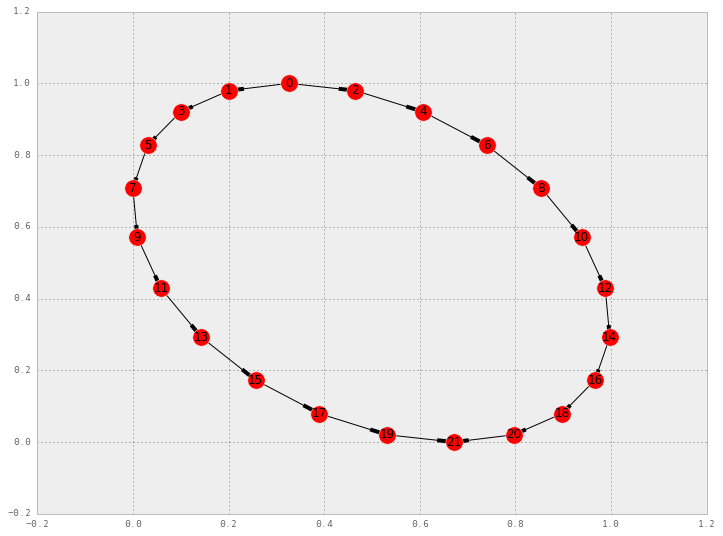

In [30]:
get_entropy_clean_bubble(10, 1, printGraph=True)

In [ ]:
get_entropy_clean_bubble(5, 1, printGraph=True)

In [76]:
results_clean_w1 = []
results_clean_w3 = []
results_clean_w100 = []
for n0 in range(7,33+1,4):
    results_clean_w1.append((n0, get_entropy_clean_bubble(n0, 1)))
    results_clean_w3.append((n0, get_entropy_clean_bubble(n0, 3)))
    results_clean_w100.append((n0, get_entropy_clean_bubble(n0, 100)))

NameError: global name 'path_transfer' is not defined

A entropia do caminho cresce linearmente a medida que o número de nós na bolha aumenta. O número de nós numa bolha pode ser relacionado ao tamanho do k-mer usado na construção do grafo já que SNPs formam bolhas contendo k-mer nós + 2 (nó junção inicial e nó fechamento). Essa afirmação só é válida para bolhas limpas (clean bubbles).

In [117]:
size_bubbles_w1 = [s[0] for s in results_clean_w1]
entropy_bubbles_w1 = [e[1] for e in results_clean_w1]

size_bubbles_w3 = [s[0] for s in results_clean_w3]
entropy_bubbles_w3 = [e[1] for e in results_clean_w3]

size_bubbles_w100 = [s[0] for s in results_clean_w100]
entropy_bubbles_w100 = [e[1] for e in results_clean_w100]

plt.plot(size_bubbles_w1, entropy_bubbles_w1)
plt.plot(size_bubbles_w3, entropy_bubbles_w3)
plt.plot(size_bubbles_w3, entropy_bubbles_w100)

NameError: name 'results_clean_w1' is not defined

In [78]:
np.array(entropy_bubbles_w1)-np.array(entropy_bubbles_w3)

array([], dtype=float64)

Rascunhando cálculos determinei a centralidade do nó da primeira bifurcação, $i$, denominado $C_H(i)$ equivalendo à expressão,

$C_H(i) = \frac{(outDegree(i)\ast N + 1)}{outDegree(i)} $,

com $N$ sendo o número de nós entre as bifurcações para todos os pesos de arestas iguais a 1 (sem peso).

**TODO:** descobrir a diferença entre a entropia do caminho com peso igual a 1 e os caminhos com peso W.

### Bonchev metric

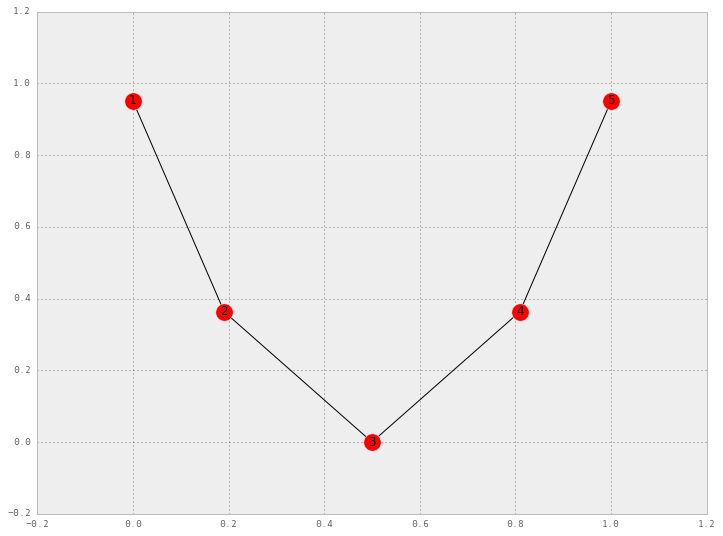

In [31]:
G_VI = nx.Graph()
G_VI.add_edge(1,2)
G_VI.add_edge(2,3)
G_VI.add_edge(3,4)
G_VI.add_edge(4,5)

pos = nx.spectral_layout(G_VI)
nx.draw_networkx(G_VI, pos=pos)

In [32]:
G_VII = nx.Graph()
G_VII.add_edge(1,2)
G_VII.add_edge(2,3)
G_VII.add_edge(3,5)
G_VII.add_edge(3,4)

G_VIII = nx.Graph()
G_VIII.add_edge(2,5)
G_VIII.add_edge(5,3)
G_VIII.add_edge(5,4)
G_VIII.add_edge(5,1)

In [169]:
def entropy_bonchev_shannon(G):
    nVertices = len(nx.nodes(G))
    # print "Number of vertices: ",nVertices
    I_mean = 0
    M = {}
    dist_back = []
#     normalizing = (nVertices**2-nVertices)
    normalizing = nVertices*(nVertices-1)    #(N-1)N
    for node_i in nx.nodes(G):
        for node_j in nx.nodes(G):
            if node_j >= node_i:
                try:
                    dist = len(nx.shortest_path(G, source=node_i, target=node_j))-1
                except nx.NetworkXNoPath:
                    dist = 0
                # print "Dist (", node_i,",",node_j,") = ", dist
                if dist in dist_back:
                    M[dist] += 1
                else:
                    M[dist] = 1
                    dist_back.append(dist)
    for i in M.keys():
        if i != 0:
            # print "key: ",i
            #log_pi = np.log(M[i])-np.log(nVertices**2)
            #pi = np.exp(log_pi)
            pi = float(M[i])/normalizing
            I_mean -= pi * np.log2(pi)
    # print M
    return I_mean, M, normalizing

In [155]:
from networkx.algorithms import isomorphism

G_I = nx.Graph()
G_I.add_edge(1,2)
# G_I.add_edge(2,3)
# G_I.add_edge(3,1)
G_I.add_edge(1,5)
G_I.add_edge(2,5)
G_I.add_edge(2,6)
G_I.add_edge(5,7)
G_I.add_edge(5,4)
G_I.add_edge(3,4)
G_I.add_edge(2,3)

G_B = nx.DiGraph()
G_B.add_edge(1,2)
G_B.add_edge(2,3)

def entropy_rashevsky(G_I, digraph=False):
    if digraph:
        GM = isomorphism.DiGraphMatcher(G_I, G_I)
    else:
        GM = isomorphism.GraphMatcher(G_I, G_I)
    nNodes = len(nx.nodes(G_I))
    numBig = 0
    for sets in list(GM.isomorphisms_iter()):
#         print "---------------"
#         print sets
#         print "---------------"
        num = 0
        for (key,value) in sets.iteritems():
            #if (key != value) and (key in nodes) and (value in nodes):
            if (key != value):
                num += 1
#         print "num: ", num
        if num > numBig:
            numBig = num
            result = sets
            #    nodes.remove(key)
            #    nodes.remove(value)
            #    print "(",key,value,")"
        #print "xxxxxxxxxxxxxxx"
    if numBig == 0:
        HR = np.log2(nNodes)
        return numBig, [], [], HR
    checked_nodes = []
    rr = []
    HR = 0
    for (key,value) in result.iteritems():
        if key not in checked_nodes:
            r = []
            if key != result[key]:
                checked_nodes.append(key)
                r.append(key)
                newKey = result[key]
                while(newKey != key):
                    checked_nodes.append(newKey)
                    r.append(newKey)
                    newKey = result[newKey]          
            else:
    #             HR -= (1./nNodes)*np.log2(1./nNodes)
                r.append(key)
            pi = float(len(r))/nNodes
            HR -= pi*np.log2(pi)
            rr.append(r)
    #         print "(",key,value,")"
    #         nodes.remove(key)
    #         try:
    #             nodes.remove(value)
    #         except ValueError:
    #             continue
    return numBig, result, rr, HR


Lets consider a chain of nodes with N vertices represented in a digraph. We're going to increase the chain's size up to 1000 nodes and compute the entropy using Rashevsky and Bonchev measures. Bellow we're showing a example of a chain of size 5.

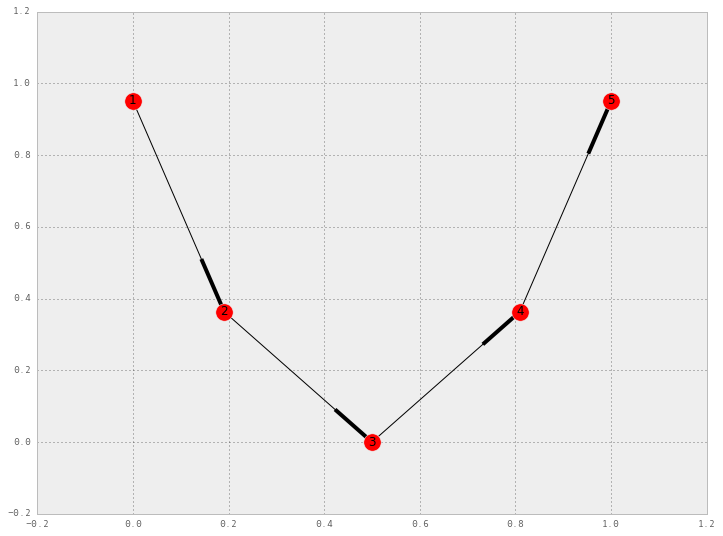

In [139]:
G_VI = nx.DiGraph()
G_VI.add_edge(1,2)
G_VI.add_edge(2,3)
G_VI.add_edge(3,4)
G_VI.add_edge(4,5)

pos = nx.spectral_layout(G_VI)
nx.draw_networkx(G_VI, pos=pos)

In [171]:
x=1
G_c = nx.DiGraph()
size_graphs = []
entropy_rashevsky_values = []
entropy_bonchev_values = []
for size in range(3, 1003+1, 100):
    print "Construct chain size: ", size
    for i in range(x+1,size):
        G_c.add_edge(x,i)
        x+=1
        
    size_graphs.append(len(nx.nodes(G_c)))
    _, _, _, HR = entropy_rashevsky(G_c, digraph=True)
    HB, _, _ = entropy_bonchev_shannon(G_c)
    entropy_rashevsky_values.append(HR)
    entropy_bonchev_values.append(HB)

Construct chain size:  3
Construct chain size:  103
Construct chain size:  203
Construct chain size:  303
Construct chain size:  403
Construct chain size:  503
Construct chain size:  603
Construct chain size:  703
Construct chain size:  803
Construct chain size:  903
Construct chain size:  1003


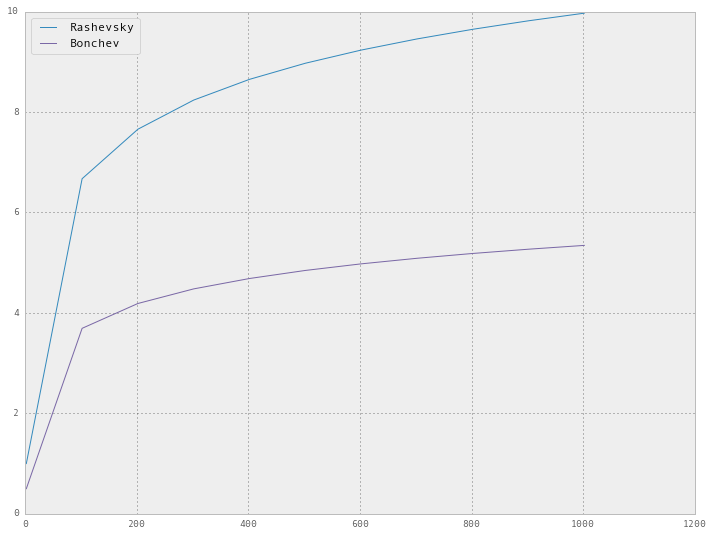

In [173]:
plt.plot(size_graphs, entropy_rashevsky_values, label='Rashevsky')
plt.plot(size_graphs, entropy_bonchev_values, label='Bonchev')
plt.legend(loc=2)

In [ ]:
entropy_rashevsky(G_B, digraph=True)

In [137]:
entropy_bonchev_shannon(G_B)

(0.95914791702724478, {0: 6, 1: 2, 2: 1}, 6)

In [133]:
-np.sum(entropy([4./10, 3./10, 2./10, 1./10]))

1.8464393446710154

In [134]:
-np.sum(entropy([3./12, 4./12, 3./12]))

1.5283208335737188

In [135]:
-np.sum(entropy([5./20, 6./20, 6./20,4./20]))

2.0065649754771964

In [136]:
I_VI = entropy_bonchev_shannon(G_VI)
I_VI

(1.8464393446710154, {0: 5, 1: 8, 2: 6, 3: 4, 4: 2}, 20)

In [124]:
I_VII = entropy_bonchev_shannon(G_VII)
I_VII

(1.5219280948873621, {0: 5, 1: 8, 2: 8, 3: 4}, 20)

### Explorando non-clean bubbles

O exemplo explorado refere-se ao grafo mostrado na fig A.

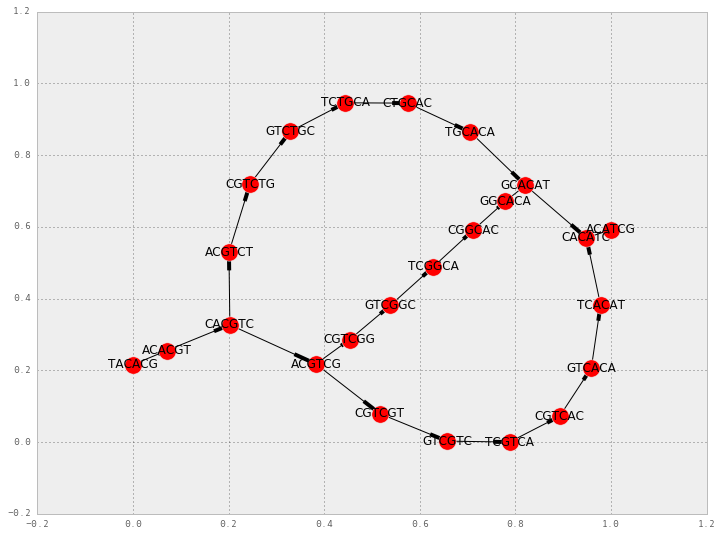

In [305]:
G_A = nx.DiGraph()
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"],dicSeqRef["links"]]:
    for edge in difpath:
        G_A.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_A)
nx.draw_networkx(G_A, pos=pos)

In [306]:
C_A = path_transfer("CACGTC", G_A)

PATH:  ['CACGTC', 'ACGTCG', 'CGTCGT', 'GTCGTC', 'TCGTCA']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGTC']
1.0 2
no testado:  CGTCGT
out:  ['TCGTCA']
1.0 2
no testado:  GTCGTC
out:  ['CGTCAC']
1.0 2
ultimo no testado:  TCGTCA
('pij_p:', 0.013888888888888888)
PIJ:  0.0138888888889
PATH:  ['CACGTC', 'ACGTCG', 'CGTCGG']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGGC']
1.0 2
ultimo no testado:  CGTCGG
('pij_p:', 0.05555555555555555)
PIJ:  0.0555555555556
PATH:  ['CACGTC', 'ACGTCG', 'CGTCGT', 'GTCGTC']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGTC']
1.0 2
no testado:  CGTCGT
out:  ['TCGTCA']
1.0 2
ultimo no testado:  GTCGTC
('pij_p:', 0.027777777777777776)
PIJ:  0.0277777777778
PATH:  ['CACGTC', 'ACGTCT', 'CGTCTG', 'GTCTGC', 'TCTGCA', 'CTGCAC', 'TGCACA', 'GCACAT', 'CACATC

In [311]:
C_A

3.2046450097076242

PATH:  [0]
out:  [1, 2]
1.0 3
ultimo no testado:  0
('pij_p:', 0.3333333333333333)
PIJ:  0.333333333333
PATH:  [0, 1]
out:  [1, 2]
1.0 3
no testado:  0
out:  [3]
1.0 2
ultimo no testado:  1
('pij_p:', 0.16666666666666666)
PIJ:  0.166666666667
PATH:  [0, 2]
out:  [1, 2]
1.0 3
no testado:  0
out:  [4]
1.0 2
ultimo no testado:  2
('pij_p:', 0.16666666666666666)
PIJ:  0.166666666667
PATH:  [0, 1, 3]
out:  [1, 2]
1.0 3
no testado:  0
out:  [3]
1.0 2
no testado:  1
out:  [5]
1.0 2
ultimo no testado:  3
('pij_p:', 0.08333333333333333)
PIJ:  0.0833333333333
PATH:  [0, 2, 4]
out:  [1, 2]
1.0 3
no testado:  0
out:  [4]
1.0 2
no testado:  2
out:  [6]
1.0 2
ultimo no testado:  4
('pij_p:', 0.08333333333333333)
PIJ:  0.0833333333333
PATH:  [0, 1, 3, 5]
out:  [1, 2]
1.0 3
no testado:  0
out:  [3]
1.0 2
no testado:  1
out:  [5]
1.0 2
no testado:  3
out:  [7]
1.0 2
ultimo no testado:  5
('pij_p:', 0.041666666666666664)
PIJ:  0.0416666666667
PATH:  [0, 2, 4, 6]
out:  [1, 2]
1.0 3
no testado:  0
out:  [

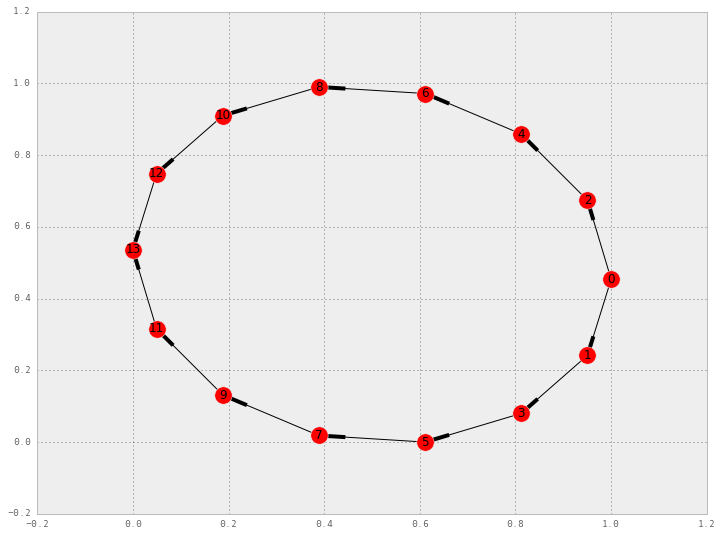

In [309]:
clean_n6 = get_entropy_clean_bubble(6, 1, printGraph=True)

In [310]:
clean_n6

2.88704583405449

**Exemplo B**

In [312]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",7, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",7, "suit")
dicSeqRef =    set_g_json("TACACGTCGTCACATCG",7, "resolved")
dicSeqDummy3 = set_g_json("TACACGTCTTCACATCG",7, "resolved")

In [313]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
dataDummy3 = dicSeqDummy3['links']
dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2 + dataDummy3 + dataRef)

In [314]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-B"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-B', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

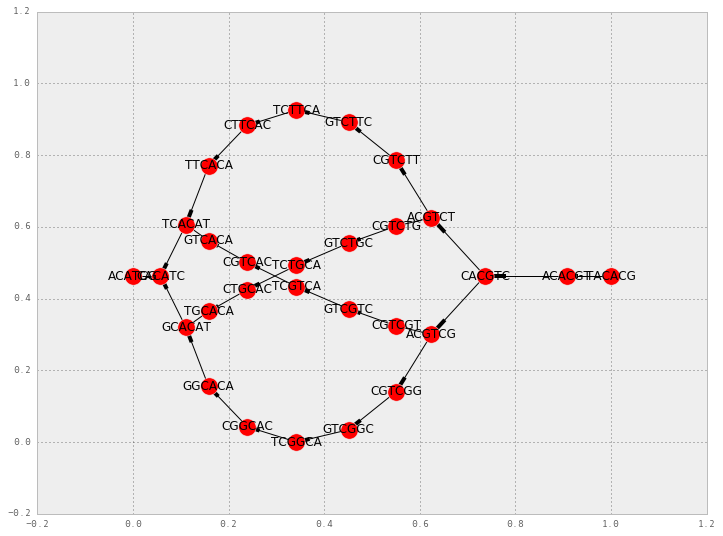

In [315]:
G_A = nx.DiGraph()
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"],dicSeqRef["links"],dicSeqDummy3["links"]]:
    for edge in difpath:
        G_A.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_A)
nx.draw_networkx(G_A, pos=pos)

In [317]:
C_B = path_transfer("CACGTC", G_A)

PATH:  ['CACGTC', 'ACGTCG', 'CGTCGT', 'GTCGTC', 'TCGTCA']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGTC']
1.0 2
no testado:  CGTCGT
out:  ['TCGTCA']
1.0 2
no testado:  GTCGTC
out:  ['CGTCAC']
1.0 2
ultimo no testado:  TCGTCA
('pij_p:', 0.013888888888888888)
PIJ:  0.0138888888889
PATH:  ['CACGTC', 'ACGTCG', 'CGTCGG']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGGC']
1.0 2
ultimo no testado:  CGTCGG
('pij_p:', 0.05555555555555555)
PIJ:  0.0555555555556
PATH:  ['CACGTC', 'ACGTCG', 'CGTCGT', 'GTCGTC']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGTC']
1.0 2
no testado:  CGTCGT
out:  ['TCGTCA']
1.0 2
ultimo no testado:  GTCGTC
('pij_p:', 0.027777777777777776)
PIJ:  0.0277777777778
PATH:  ['CACGTC', 'ACGTCT', 'CGTCTT', 'GTCTTC', 'TCTTCA', 'CTTCAC', 'TTCACA', 'TCACAT', 'CACATC

In [318]:
C_B

3.5027152789797031

In [319]:
# "TACACGTCGGCACATCG","TACACGTCTGCACATCG","TACACGTCTTCACATCG"
# Check variant in position 9 -----** and a second variant in position 10 branching from two alleles (Dummy1 and Dummy3)
# The Dummy1 is colored in green and Dummy2 has black line while branching variants are dashed lines
dicSeqDummy1 = set_g_json("TACACGTCGGCACATCG",7, "licensing")
dicSeqDummy2 = set_g_json("TACACGTCTGCACATCG",7, "suit")
dicSeqRef =    set_g_json("TACACGTCGTCACATCG",7, "resolved")
dicSeqDummy3 = set_g_json("TACACGTCTCCACATCG",7, "resolved")

In [320]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
dataDummy3 = dicSeqDummy3['links']
dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2 + dataDummy3 + dataRef)

In [321]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-C"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-C', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

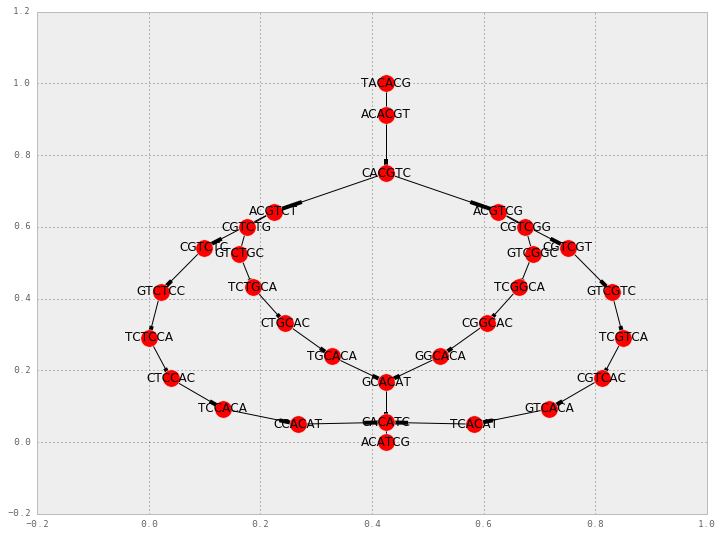

In [322]:
G_A = nx.DiGraph()
for difpath in [dicSeqDummy1["links"],dicSeqDummy2["links"],dicSeqRef["links"],dicSeqDummy3['links']]:
    for edge in difpath:
        G_A.add_edge(edge["source"], edge["target"],weight=1)
pos = nx.spectral_layout(G_A)
nx.draw_networkx(G_A, pos=pos)

In [323]:
C_C = path_transfer("CACGTC", G_A)

PATH:  ['CACGTC', 'ACGTCG', 'CGTCGT', 'GTCGTC', 'TCGTCA']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no testado:  ACGTCG
out:  ['GTCGTC']
1.0 2
no testado:  CGTCGT
out:  ['TCGTCA']
1.0 2
no testado:  GTCGTC
out:  ['CGTCAC']
1.0 2
ultimo no testado:  TCGTCA
('pij_p:', 0.013888888888888888)
PIJ:  0.0138888888889
PATH:  ['CACGTC', 'ACGTCT', 'CGTCTC', 'GTCTCC', 'TCTCCA', 'CTCCAC', 'TCCACA', 'CCACAT']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCTC', 'CGTCTG']
1.0 3
no testado:  ACGTCT
out:  ['GTCTCC']
1.0 2
no testado:  CGTCTC
out:  ['TCTCCA']
1.0 2
no testado:  GTCTCC
out:  ['CTCCAC']
1.0 2
no testado:  TCTCCA
out:  ['TCCACA']
1.0 2
no testado:  CTCCAC
out:  ['CCACAT']
1.0 2
no testado:  TCCACA
out:  ['CACATC']
1.0 2
ultimo no testado:  CCACAT
('pij_p:', 0.001736111111111111)
PIJ:  0.00173611111111
PATH:  ['CACGTC', 'ACGTCG', 'CGTCGG']
out:  ['ACGTCG', 'ACGTCT']
1.0 3
no testado:  CACGTC
out:  ['CGTCGG', 'CGTCGT']
1.0 3
no tes

In [324]:
C_C

3.5061875012019259

## Complex SNP (bubble length < k)

In [57]:
dicSeqDummy1 = set_g_json("AATCGAGATAGA",5, "licensing")
dicSeqDummy2 = set_g_json("AATCGATATAGA",5, "suit")

In [58]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
#dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2)

In [59]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-complex"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-complex', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

## SNPs + deletions in one bubble

Structure where two SNPs and one Deletion combine to form one bubble.

In [193]:
# MSA
# read1    CATCGTATGCTA---CAGG
# read2    CATCGCATGTTAGCTCAGG
#          ***** *** **   ****

In [194]:
dicSeqDummy1 = set_g_json("CATCGTATGCTACAGG",5, "licensing")
dicSeqDummy2 = set_g_json("CATCGCATGTTAGCTCAGG",5, "suit")

In [195]:
dataDummy1 = dicSeqDummy1['links']
dataDummy2 = dicSeqDummy2['links']
#dataRef = dicSeqRef['links']

data = json.dumps(dataDummy1 + dataDummy2)

In [196]:
html_template = Template('''
<style> $css_text </style>
<div id="graph-div-indel1"></div>
<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div-indel1', 'python_data': data})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))